In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import seaborn as sns
sns.set_style("whitegrid")
matplotlib.rcParams["font.family"] = "DejaVu Sans"


In [2]:
# Read dataframes in the dataframes folder
full_df = pd.read_csv("../dataframes/full_dataframe.csv", low_memory=False)
filtered_df = pd.read_csv("../dataframes/filtered_df.csv", low_memory=False)
airports_df = pd.read_csv("../dataframes/airports_df.csv", low_memory=False)

# Update column names
full_df = full_df.rename(columns={"Origin": "DepAirportCode",
                                  "Dest"  : "ArrAirportCode"})

In [3]:
# Basic cleaning
full_df['DepDelayMinutes'] = pd.to_numeric(full_df['DepDelayMinutes'], errors='coerce')
full_df['ArrDelayMinutes'] = pd.to_numeric(full_df['ArrDelayMinutes'], errors='coerce')
full_df = full_df.dropna(subset=['AirlineName', 'DepDelayMinutes', 'ArrDelayMinutes'])

In [4]:
# Basic flag columns
full_df["DepOTP"] = full_df["DepDelayMinutes"] <= 0
full_df["ArrOTP"] = full_df["ArrDelayMinutes"] <= 0
full_df["OTP15"]  = (full_df["DepDelayMinutes"].abs() <= 15) & \
                    (full_df["ArrDelayMinutes"].abs() <= 15)

# An “Extreme” departure delay  
full_df["ExtremeDelay"] = (full_df["DepDelayMinutes"] > 60) | \
                          full_df.get("Cancelled", 0).fillna(0).astype(bool)

# Composite reliability score for ease of viewing
full_df["Reliability"] = (
      0.4*full_df["DepOTP"].astype(int)
    + 0.4*full_df["ArrOTP"].astype(int)
    + 0.2*(~full_df["ExtremeDelay"]).astype(int)
)

In [5]:
kpi_cols = ["DepOTP", "ArrOTP", "OTP15", "ExtremeDelay", "Reliability"]

by_airline = (full_df.groupby("AirlineName")[kpi_cols]
                      .mean().mul(100).round(2)
                      .sort_values("Reliability", ascending=False))

by_airport = (full_df.groupby("DepAirportCode")[kpi_cols]
                      .mean().mul(100).round(2))

by_airline.head()


,DepOTP,ArrOTP,OTP15,ExtremeDelay,Reliability
AirlineName,,,,,
Hawaiian Airlines,77.35,68.13,91.33,1.06,77.98
Air Wisconsin,74.81,66.67,78.79,6.51,75.29
ATA Airlines,72.09,59.23,78.96,4.82,71.57
Kalitta Air,68.80,60.19,89.77,1.49,71.30
SkyWest Airlines,69.27,61.64,80.42,5.73,71.22


In [6]:
by_airport.head()

,DepOTP,ArrOTP,OTP15,ExtremeDelay,Reliability
DepAirportCode,,,,,
ABE,73.39,63.19,80.29,6.57,73.32
ABI,76.91,69.28,85.40,5.45,77.39
ABQ,63.93,62.28,81.75,3.98,69.69
ABR,71.43,72.73,84.42,5.19,76.62
ABY,63.28,49.72,73.45,9.04,63.39


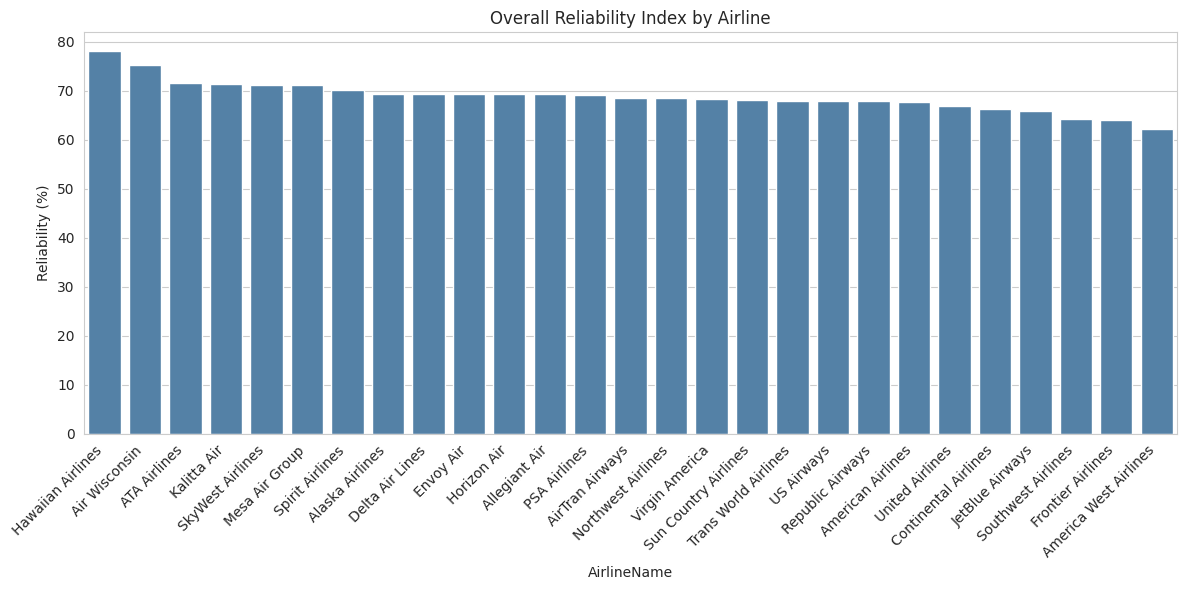

In [7]:
# Bar plot of Reliability by airline
plt.figure(figsize=(12,6))
sns.barplot(x=by_airline.index, y=by_airline["Reliability"], color="steelblue")
plt.xticks(rotation=45, ha="right") 
plt.ylabel("Reliability (%)")
plt.title("Overall Reliability Index by Airline")
plt.tight_layout()
plt.savefig('figure1.png')
plt.show()


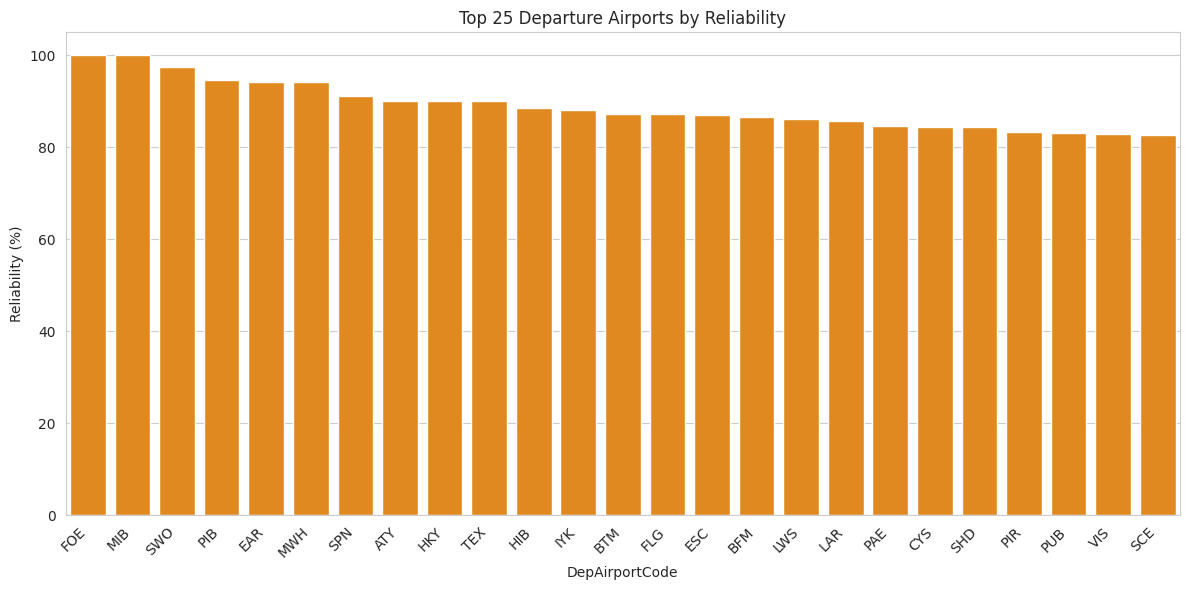

In [8]:
# Bar plot of Reliability by airport
# keeping it to 25 airports
N = 25                                              
top_airport = by_airport.nlargest(N, "Reliability")

plt.figure(figsize=(12, 6))
sns.barplot(x=top_airport.index, y=top_airport["Reliability"], color="darkorange")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Reliability (%)")
plt.title(f"Top {N} Departure Airports by Reliability")
plt.tight_layout()
plt.savefig('figure2.png')
plt.show()

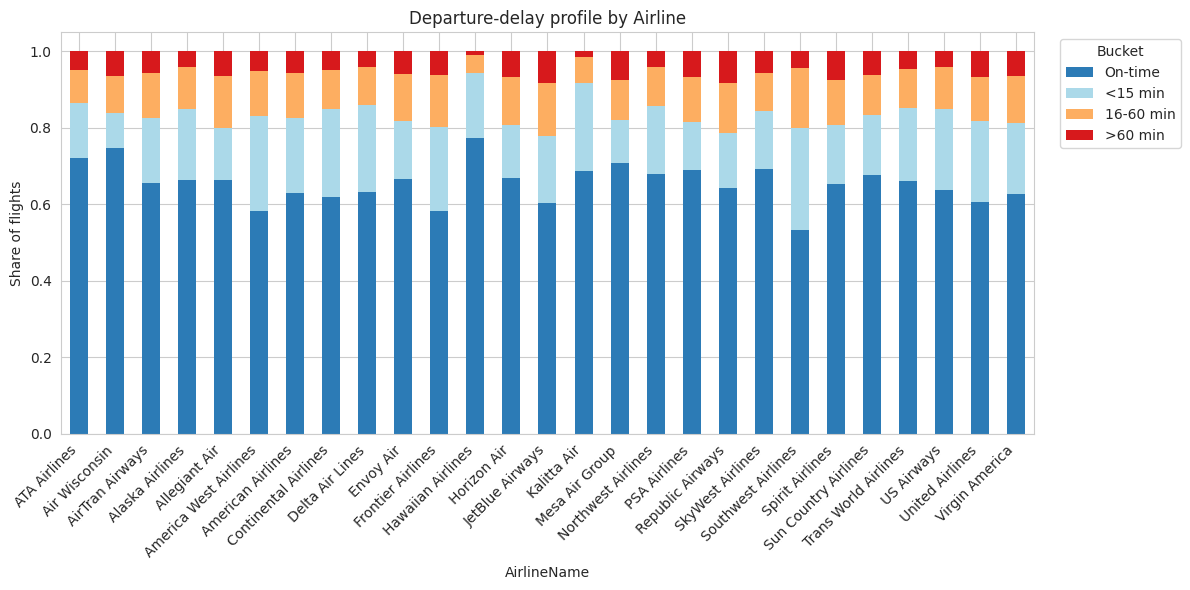

In [9]:
# Setting up the buckets
def bucket(mins):
    if mins <= 0:   return "On‑time"
    if mins <= 15:  return "<15 min"
    if mins <= 60:  return "16‑60 min"
    return ">60 min"
full_df["DelayBucket"] = full_df["DepDelayMinutes"].apply(bucket)
bucket_counts = (
    full_df.groupby(["AirlineName", "DelayBucket"])
           .size()
           .unstack(fill_value=0)
)

# Stacking bucket order
order = ["On‑time", "<15 min", "16‑60 min", ">60 min"]
bucket_counts = bucket_counts[order]

# normalise rows to get shares
share = bucket_counts.div(bucket_counts.sum(axis=1), axis=0)

# plot
ax = share.plot(kind="bar",
                stacked=True,
                figsize=(12, 6),
                color=["#2c7bb6", "#abd9e9", "#fdae61", "#d7191c"],
                linewidth=0)

plt.ylabel("Share of flights")
plt.title("Departure‑delay profile by Airline")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Bucket", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig('figure3.png')
plt.show()


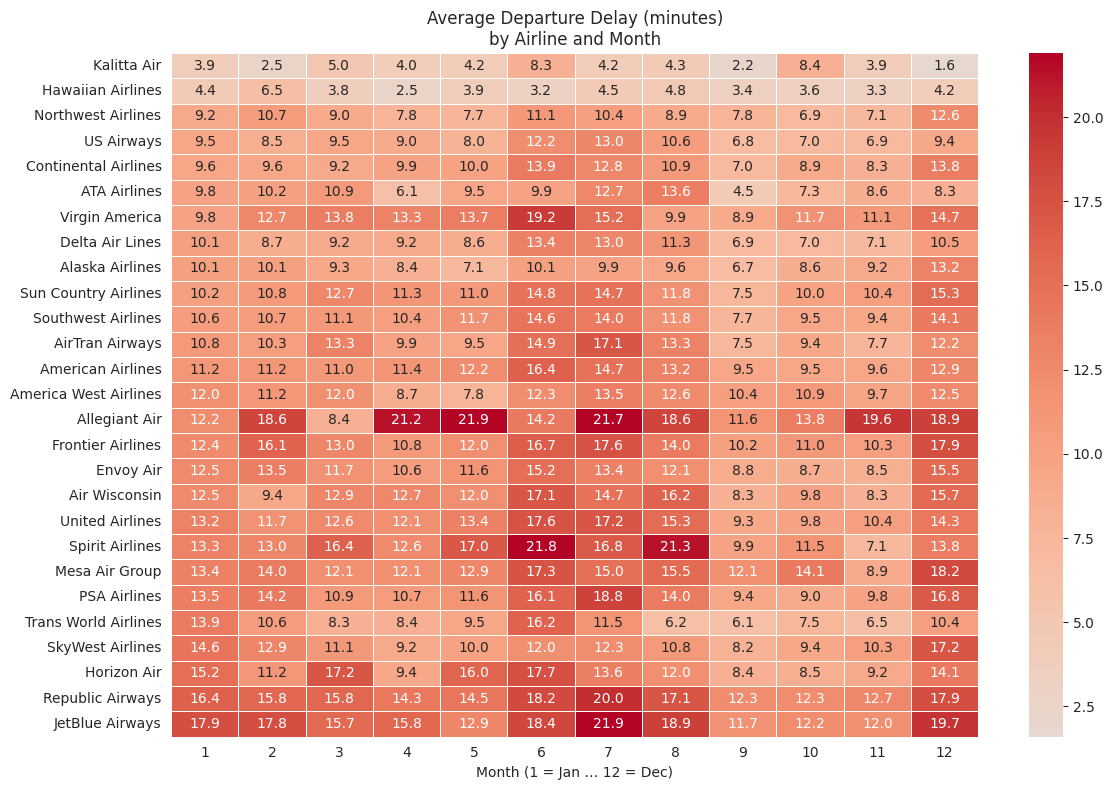

In [10]:
# Build a pivot table for heatmap
delay_pivot = (full_df.pivot_table
                (index="AirlineName",
                 columns="Month",
                 values="DepDelayMinutes",
                 aggfunc="mean").round(1).sort_values(1, ascending=True)
)

# plot static heat‑map
plt.figure(figsize=(12, 8))
sns.heatmap(delay_pivot,
            cmap="coolwarm",
            center=0,
            linewidths=.5,
            linecolor="white",
            annot=True, fmt=".1f")

plt.title("Average Departure Delay (minutes)\nby Airline and Month")
plt.xlabel("Month (1 = Jan … 12 = Dec)")
plt.ylabel("")
plt.tight_layout()
plt.savefig('figure4.png')
plt.show()


In [66]:
# prepping the treemap using Month name and OTP15
full_df["MonthName"] = pd.to_datetime(full_df["FlightDate"]) \
                   .dt.month_name() 
summary = (
    full_df.groupby(["Month","AirlineName"])
      .agg(Flights=("OTP15","count"),
           AvgOTP15=("OTP15","mean"))
      .reset_index()
)
summary["AvgOTP15"] *= 100

# draw treemap with month as top level
fig = px.treemap(
    full_df.groupby(["MonthName","AirlineName"])
      .agg(Flights=("OTP15","count"), AvgOTP15=("OTP15","mean"))
      .reset_index()
      .assign(AvgOTP15=lambda d: d["AvgOTP15"]*100),
    path=["MonthName","AirlineName"],
    values="Flights",
    color="AvgOTP15",
    color_continuous_scale="Viridis",
    hover_data={"Flights":True, "AvgOTP15":":.1f"},
    width=1400, height=900,
    title="Monthly Airline Flight Volume & On‑Time (≤15 min) Performance"
)
fig.update_layout(margin=dict(t=50,l=25,r=25,b=25))
fig.update_traces(textinfo="label+value")
fig.show()
